# Test code notebook
### Imports the saved trained model and tests it against multiple datasets for evaluation metrics

In [ ]:
!pip install datasets torchinfo torchmetrics piqa pytorch-msssim  empatches imgviz pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import numpy as np
import time
from tqdm.auto import tqdm
import cv2
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from datasets import load_dataset
import math
from torch.utils.data import DataLoader
import PIL
from PIL import Image, ImageOps
from skimage.metrics import structural_similarity
import random
from typing import List, Dict, Tuple
from torchinfo import summary

In [ ]:
from torchvision.transforms import functional as F
import torch.nn.functional as nnF
import datasets
from datasets import load_dataset
from empatches import EMPatches
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import imgviz
from tqdm.auto import tqdm
from typing import List, Tuple, Dict
from ignite.metrics import SSIM, PSNR
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio, MultiScaleStructuralSimilarityIndexMeasure

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class ConvModule(nn.Module):
  def __init__(self, n_filters=64):
    super(ConvModule, self).__init__()
    self.n_filters = n_filters

    # Stage-1
    self.conv1_1 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=1, padding='same', stride=1) # Single 1x1 : Padding = 0
    self.conv1_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First layer of two 3x3 : Padding = 1 for the rest
    self.conv1_3 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second layer of two 3x3

    # Stage-2
    self.conv2_1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First 3x3
    self.conv2_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second 3x3

    self.add_residue = lambda x: x[0] + x[1]

    self.relu = nn.ReLU()

  def forward(self, x):
    # 1x1
    way1 = self.conv1_1(x)
    # 3x3
    way2 = self.conv1_2(x)
    way2 = self.relu(way2)
    way2 = self.conv1_3(way2)

    # Adding output of stage-1
    residue = self.add_residue([way1, way2])

    # Stage-2
    x = self.relu(residue)
    x = self.conv2_1(x)
    x = self.relu(x)
    x = self.conv2_2(x)

    # Adding residue of stage-1 with output of stage-2
    x = self.add_residue([x, residue])
    out = self.relu(x)
    return out

In [ ]:
class LLCNN(nn.Module):
  def __init__(self, channels=3, blocks=3):
    super(LLCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3, padding='same', stride=1)
    self.relu = nn.ReLU()
    self.conv_modules = nn.Sequential(*[ConvModule() for _ in range(blocks)])

    self.conv2 = nn.Conv2d(64, channels, kernel_size=1, padding=0, stride=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv_modules(x)
    out = self.conv2(x)
    return out

In [ ]:
class SEConvModule(nn.Module):
  def __init__(self, n_filters=64, r=16):
    super(SEConvModule, self).__init__()
    self.n_filters = n_filters

    # Stage-1
    self.conv1_1 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=1, padding='same', stride=1) # Single 1x1 : Padding 0
    self.conv1_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First layer of two 3x3 : Padding 1 for the rest
    self.conv1_3 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second layer of two 3x3

    # Stage-2
    self.conv2_1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First 3x3
    self.conv2_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second 3x3

    # New SE Block
    self.se = torchvision.ops.SqueezeExcitation(n_filters, r)

    self.add_residue = lambda x: x[0] + x[1]

    self.relu = nn.ReLU()

  def forward(self, x):
    # 1x1
    way1 = self.conv1_1(x)
    # 3x3
    way2 = self.conv1_3(self.relu(self.conv1_2(x)))

    # Adding output of stage-1
    residue = self.add_residue([way1, way2])

    # Stage-2
    # Adding residue of stage-1 with output of stage-2
    x = self.relu(residue)
    x = self.conv2_1(x)
    x = self.relu(x)
    x = self.conv2_2(x)
    x = self.add_residue([x, residue])
    x = self.se(x)
    x = self.relu(x)

    return x
    # return self.relu(self.se(self.add_residue([self.conv2_2(self.relu(self.conv2_1(self.relu(residue)))), residue])))

In [ ]:
class SELLCNN(nn.Module):
  def __init__(self, channels=3, se_blocks=3, blocks=3):
    super(SELLCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3, padding='same', stride=1)
    self.relu = nn.ReLU()
    self.conv_modules = nn.Sequential(*[SEConvModule() for _ in range(se_blocks)])
    self.conv_modules_2 = nn.Sequential(*[ConvModule() for _ in range(blocks)])

    self.conv2 = nn.Conv2d(64, channels, kernel_size=1, padding=0, stride=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv_modules(x)
    x = self.conv_modules_2(x)
    x = self.conv2(x)

    return x
    # return self.conv2(self.conv_modules_2(self.conv_modules(self.relu(self.conv1(x)))))

In [ ]:
def extract_patches(images: torch.Tensor, permute=True, patch_size=17, stride=3, overlap=None):
  if permute:
    images = images.permute(1,2,0)
  emp = EMPatches()
  patches, indices = emp.extract_patches(images, patchsize=patch_size, stride=stride, overlap=overlap)
  return (patches, indices)

In [ ]:
def plot_tiled(images: List[torch.Tensor]):
  unnormalized_image = []
  for i in range(len(images)):
    unnormalized_image.append(images[i]*255)
  tiled = imgviz.tile(list(map(np.uint8, unnormalized_image)))
  plt.figure()
  plt.axis(False)
  plt.imshow(tiled)

In [ ]:
def merge_patch(patches: List[torch.Tensor], indices: List[Tuple], mode = 'avg'):
  emp = EMPatches()
  merged_patches = emp.merge_patches(patches, indices, mode=mode)
  return merged_patches

In [ ]:
image_transforms = transforms.Compose([
      transforms.Resize(size=(224, 224)),
      transforms.ToTensor()
  ])

def load_images(dir: List[str], transforms: torchvision.transforms.Compose = image_transforms):
  images = []

  for file in tqdm(dir, unit="images"):
    with Image.open(file) as img:
      img = transforms(img).numpy()
      if(img.shape[0] == 3):
          images.append(img)
  return torch.from_numpy(np.array(images))

In [ ]:
set14 = load_dataset('eugenesiow/Set14')
set14 = set14['validation']['hr']
set14 = load_images(set14)
set5 = load_dataset('eugenesiow/Set5')
set5 = set5['validation']['hr']
set5 = load_images(set5)

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset set14 downloaded and prepared to /root/.cache/huggingface/datasets/eugenesiow___set14/bicubic_x2/1.0.0/aeded014732d03e88321cef292f60e9ff6cc73e271c273302a82f089f7654d13. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?images/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset set5 downloaded and prepared to /root/.cache/huggingface/datasets/eugenesiow___set5/bicubic_x2/1.0.0/e0c6fb24ad5c097bcc602e43704e322b619ce96a3bb212e085cabdafae69727f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?images/s]

In [ ]:
# TRYING DIFFERENT LAYERS CONFIGS

# model_se = LLCNN().to(device)
# model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/LLCNN.pth", map_location=torch.device("cpu"))["model_state_dict"])
# model_se = SELLCNN(se_blocks=1, blocks=2).to(device)
# model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_new.pth", map_location=torch.device("cpu"))["model_state_dict"])
# model_se = SELLCNN(se_blocks=3, blocks=3).to(device)
# model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_3_3.pth", map_location=torch.device("cpu"))["model_state_dict"])
model_se = SELLCNN(se_blocks=3, blocks=0).to(device)
# model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0.pth", map_location=torch.device("cpu"))["model_state_dict"])
model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr.pth", map_location=torch.device("cpu"))["model_state_dict"])

<All keys matched successfully>

In [ ]:
idx = 9
darken = 4

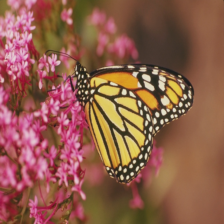

In [ ]:
transforms.ToPILImage()(set14[idx]).save("truth.png")
transforms.ToPILImage()(set14[idx])

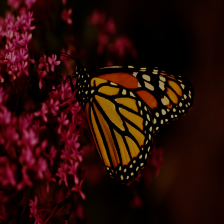

In [ ]:
transforms.ToPILImage()(transforms.functional.adjust_gamma(set14[idx], darken)).save("darkened.png")
transforms.ToPILImage()(transforms.functional.adjust_gamma(set14[idx], darken))

In [ ]:
patches, indices = extract_patches(transforms.functional.adjust_gamma(set14[idx], darken), patch_size=224, stride=7)

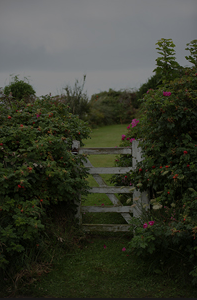

In [ ]:
Image.open('test3.png').convert('RGB')

In [ ]:
img = transforms.ToTensor()(Image.open('test3.png').convert('RGB'))

In [ ]:
img.shape

torch.Size([3, 300, 197])

In [ ]:
patches, indices = extract_patches(img, patch_size=1200, stride=7)

In [ ]:
len(patches), patches[0].shape

(1, torch.Size([300, 197, 3]))

In [ ]:
plot_line = []
for x in patches[:5]:
  plot_line.append(x*255)

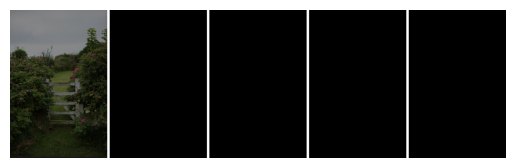

In [ ]:
tiled = imgviz.tile(list(map(np.uint8, plot_line)),border=(255,255,255), shape=(1,5), border_width=5)
plt.figure()
plt.axis(False)
plt.imshow(tiled)

In [ ]:
plt.imsave("tiled.png", tiled)

In [ ]:
enhanced = []

In [ ]:
for patch in patches:
  enhanced.append(model_se(patch.permute(2,0,1).to(device)).permute(1,2,0).detach().cpu().numpy())

In [ ]:
len(enhanced), enhanced[0].shape

(1, (300, 197, 3))

In [ ]:
enhanced_image = merge_patch(enhanced, indices)
enhanced_image = np.clip(enhanced_image, 0, 1)

In [ ]:
enhanced_image.shape

(300, 197, 3)

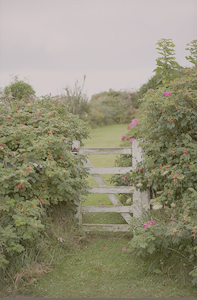

In [ ]:
Image.fromarray((enhanced_image * 255).astype(np.uint8))

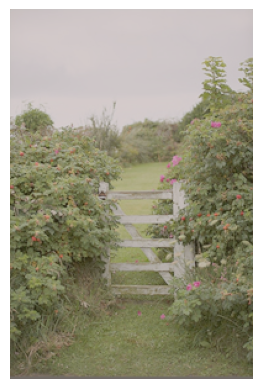

In [ ]:
plt.axis(False)
plt.imshow(enhanced_image)

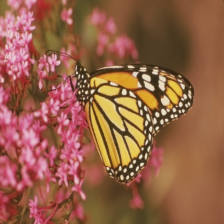

In [ ]:
pil_enhanced = transforms.ToPILImage()(torch.from_numpy(enhanced_image).permute(2,0,1))
pil_enhanced.save("output.png")
pil_enhanced

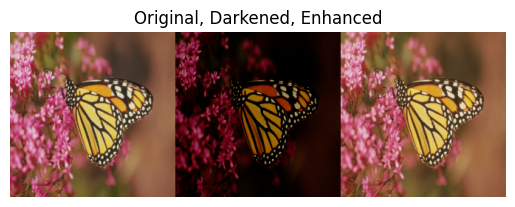

In [ ]:
tiled = imgviz.tile(list(map(np.uint8, [set14[idx].permute(1,2,0)*255, transforms.functional.adjust_gamma(set14[idx], 4).permute(1,2,0)*255, enhanced_image*255])),border=None, shape=(1,3))
plt.figure()
plt.axis(False)
plt.title("Original, Darkened, Enhanced")
plt.imshow(tiled)

In [ ]:
def loss_fn(img1, img2):
    """
    Computes the SSIM loss between two images.
    """
    # Compute the mean of the images
    mu1 = nn.functional.avg_pool2d(img1, kernel_size=8, stride=1, padding=0)
    mu2 = nn.functional.avg_pool2d(img2, kernel_size=8, stride=1, padding=0)

    # Compute the variance of the images
    sigma1 = nn.functional.avg_pool2d(img1 ** 2, kernel_size=8, stride=1, padding=0) - mu1 ** 2
    sigma2 = nn.functional.avg_pool2d(img2 ** 2, kernel_size=8, stride=1, padding=0) - mu2 ** 2

    # Compute the covariance between the images
    sigma12 = nn.functional.avg_pool2d(img1 * img2, kernel_size=8, stride=1, padding=0) - mu1 * mu2

    # Compute the SSIM
    C1 = 0.0001
    C2 = 0.001
    ssim = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2))

    # Return the negative SSIM as a loss
    return 1 - ssim.mean()

In [ ]:
x1 = torch.from_numpy(enhanced_image).permute(2,0,1).unsqueeze(0)
x2 = set14[idx].unsqueeze(0)
x1.shape, x2.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

### Metrics Evaluation

In [ ]:
from torchmetrics.functional import structural_similarity_index_measure

In [ ]:
print("SSIM: ", 1-loss_fn(x1, x2).item())

SSIM:  0.9856517314910889


In [ ]:
# ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel=7, k1=0.0001, k2=0.001)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0, gaussian_kernel=False, kernel=8, k1=0.0001, k2=0.001)

In [ ]:
psnr = PeakSignalNoiseRatio()

In [ ]:
ssim(x1,x2), psnr(x1,x2)

(tensor(0.9719), tensor(31.3118))

In [ ]:
mssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0, gaussian_kernel=False, kernel=8, k1=0.0001, k2=0.001)

## Set14 and Set5 metrics on our model

In [ ]:
darken = 3
total_custom_ssim = 0
total_ssim = 0
total_mssim = 0
total_psnr = 0
n = len(set14)
for i in range(n):
  patches, indices = extract_patches(transforms.functional.adjust_gamma(set14[i], darken), patch_size=224, stride=1)
  enhanced = []
  for patch in patches:
    enhanced.append(model_se(patch.permute(2,0,1).to(device)).permute(1,2,0).detach().cpu().numpy())
  enhanced_image = merge_patch(enhanced, indices)
  enhanced_image = np.clip(enhanced_image, 0, 1)
  x1 = torch.from_numpy(enhanced_image).permute(2,0,1).unsqueeze(0)
  x2 = set14[i].unsqueeze(0)
  total_custom_ssim += 1-loss_fn(x1, x2).item()
  total_ssim += ssim(x1,x2).item()
  total_mssim += mssim(x1,x2).item()
  total_psnr += psnr(x1,x2).item()

avg_custom_ssim = total_custom_ssim/n
avg_ssim = total_ssim/n
avg_mssim = total_mssim/n
avg_psnr = total_psnr/n

print("Average custom SSIM: ", avg_custom_ssim)
print("Average SSIM: ", avg_ssim)
print("Average MSSIM: ", avg_mssim)
print("Average PSNR: ", avg_psnr)

Average custom SSIM:  0.9541628819245559
Average SSIM:  0.9430494491870587
Average MSSIM:  0.9894915773318365
Average PSNR:  24.93691400381235


In [ ]:
darken = 3
total_custom_ssim = 0
total_ssim = 0
total_mssim = 0
total_psnr = 0
n = len(set5)
for i in range(n):
  patches, indices = extract_patches(transforms.functional.adjust_gamma(set5[i], darken), patch_size=224, stride=1)
  enhanced = []
  for patch in patches:
    enhanced.append(model_se(patch.permute(2,0,1).to(device)).permute(1,2,0).detach().cpu().numpy())
  enhanced_image = merge_patch(enhanced, indices)
  enhanced_image = np.clip(enhanced_image, 0, 1)
  x1 = torch.from_numpy(enhanced_image).permute(2,0,1).unsqueeze(0)
  x2 = set5[i].unsqueeze(0)
  total_custom_ssim += 1-loss_fn(x1, x2).item()
  total_ssim += ssim(x1,x2).item()
  total_mssim += mssim(x1,x2).item()
  total_psnr += psnr(x1,x2).item()

avg_custom_ssim = total_custom_ssim/n
avg_ssim = total_ssim/n
avg_mssim = total_mssim/n
avg_psnr = total_psnr/n

print("Average custom SSIM: ", avg_custom_ssim)
print("Average SSIM: ", avg_ssim)
print("Average MSSIM: ", avg_mssim)
print("Average PSNR: ", avg_psnr)

Average custom SSIM:  0.9048142194747925
Average SSIM:  0.8760622024536133
Average MSSIM:  0.9740289330482483
Average PSNR:  22.95602493286133


## Set14 and Set5 metrics using Histogram Equilization(HE)

In [ ]:
darken = 3
total_custom_ssim = 0
total_ssim = 0
total_mssim = 0
total_psnr = 0
n = len(set14)
for i in range(n):
  img = transforms.ToPILImage()(transforms.functional.adjust_gamma(set14[i], darken))
  enhanced_image = ImageOps.equalize(img)
  enhanced_image = np.array(enhanced_image)
  x1 = torch.from_numpy(enhanced_image).permute(2,0,1).unsqueeze(0)/255
  x2 = set14[i].unsqueeze(0)
  total_custom_ssim += 1-loss_fn(x1, x2).item()
  total_ssim += ssim(x1,x2).item()
  total_mssim += mssim(x1,x2).item()
  total_psnr += psnr(x1,x2).item()

avg_custom_ssim = total_custom_ssim/n
avg_ssim = total_ssim/n
avg_mssim = total_mssim/n
avg_psnr = total_psnr/n

print("Average custom SSIM: ", avg_custom_ssim)
print("Average SSIM: ", avg_ssim)
print("Average MSSIM: ", avg_mssim)
print("Average PSNR: ", avg_psnr)

Average custom SSIM:  0.7388788324136001
Average SSIM:  0.7143935423630935
Average MSSIM:  0.8564110306593088
Average PSNR:  15.500664857717661


In [ ]:
darken = 3
total_custom_ssim = 0
total_ssim = 0
total_mssim = 0
total_psnr = 0
n = len(set5)
for i in range(n):
  img = transforms.ToPILImage()(transforms.functional.adjust_gamma(set5[i], darken))
  enhanced_image = ImageOps.equalize(img)
  enhanced_image = np.array(enhanced_image)
  x1 = torch.from_numpy(enhanced_image).permute(2,0,1).unsqueeze(0)/255
  x2 = set5[i].unsqueeze(0)
  total_custom_ssim += 1-loss_fn(x1, x2).item()
  total_ssim += ssim(x1,x2).item()
  total_mssim += mssim(x1,x2).item()
  total_psnr += psnr(x1,x2).item()

avg_custom_ssim = total_custom_ssim/n
avg_ssim = total_ssim/n
avg_mssim = total_mssim/n
avg_psnr = total_psnr/n

print("Average custom SSIM: ", avg_custom_ssim)
print("Average SSIM: ", avg_ssim)
print("Average MSSIM: ", avg_mssim)
print("Average PSNR: ", avg_psnr)

Average custom SSIM:  0.6829909801483154
Average SSIM:  0.6685953438282013
Average MSSIM:  0.8489697694778442
Average PSNR:  15.972803688049316


## Set14 and Set5 metrics using CLAHE

In [ ]:
import cv2

In [ ]:
darken = 3
total_custom_ssim = 0
total_ssim = 0
total_mssim = 0
total_psnr = 0
n = len(set14)
for i in range(n):
  img = transforms.ToPILImage()(transforms.functional.adjust_gamma(set14[i], darken))
  pil_image = img.convert('RGB')
  open_cv_image = numpy.array(pil_image)
  open_cv_image = open_cv_image[:, :, ::-1].copy()
  image_bw = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit = 0.01, tileGridSize=(8,8))
  enhanced_image = clahe.apply(image_bw)
  enhanced_image = torch.Tensor(enhanced_image).unsqueeze(0)/255
  x1 = enhanced_image.unsqueeze(0)
  x2 = set14[i]
  x2 = transforms.Grayscale()(x2).unsqueeze(0)
  total_custom_ssim += 1-loss_fn(x1, x2).item()
  total_ssim += ssim(x1,x2).item()
  total_mssim += mssim(x1,x2).item()
  total_psnr += psnr(x1,x2).item()

avg_custom_ssim = total_custom_ssim/n
avg_ssim = total_ssim/n
avg_mssim = total_mssim/n
avg_psnr = total_psnr/n

print("Average custom SSIM: ", avg_custom_ssim)
print("Average SSIM: ", avg_ssim)
print("Average MSSIM: ", avg_mssim)
print("Average PSNR: ", avg_psnr)

Average custom SSIM:  0.5627708939405588
Average SSIM:  0.5322426099043626
Average MSSIM:  0.827697951060075
Average PSNR:  11.457907383258526


In [ ]:
darken = 3
total_custom_ssim = 0
total_ssim = 0
total_mssim = 0
total_psnr = 0
n = len(set5)
for i in range(n):
  img = transforms.ToPILImage()(transforms.functional.adjust_gamma(set5[i], darken))
  pil_image = img.convert('RGB')
  open_cv_image = numpy.array(pil_image)
  open_cv_image = open_cv_image[:, :, ::-1].copy()
  image_bw = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit = 0.01, tileGridSize=(8,8))
  enhanced_image = clahe.apply(image_bw)
  enhanced_image = torch.Tensor(enhanced_image).unsqueeze(0)/255
  x1 = enhanced_image.unsqueeze(0)
  x2 = set5[i]
  x2 = transforms.Grayscale()(x2).unsqueeze(0)
  total_custom_ssim += 1-loss_fn(x1, x2).item()
  total_ssim += ssim(x1,x2).item()
  total_mssim += mssim(x1,x2).item()
  total_psnr += psnr(x1,x2).item()

avg_custom_ssim = total_custom_ssim/n
avg_ssim = total_ssim/n
avg_mssim = total_mssim/n
avg_psnr = total_psnr/n

print("Average custom SSIM: ", avg_custom_ssim)
print("Average SSIM: ", avg_ssim)
print("Average MSSIM: ", avg_mssim)
print("Average PSNR: ", avg_psnr)

Average custom SSIM:  0.5500714659690857
Average SSIM:  0.5074051022529602
Average MSSIM:  0.8025431275367737
Average PSNR:  12.620510482788086


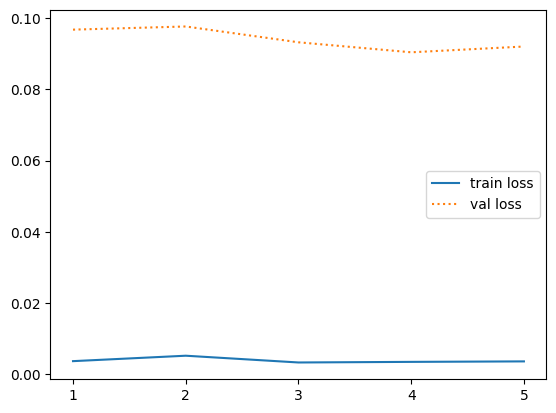

In [ ]:
saved = torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr.pth")
train_loss, val_loss = saved['train_loss'], saved['val_loss']
plt.plot(range(1, len(train_loss)+1), train_loss)
plt.plot(range(1, len(val_loss)+1), val_loss, linestyle='dotted')
plt.xticks(range(1, len(train_loss)+1))
plt.legend(labels=["train loss", "val loss"])
plt.savefig("loss curve.png")
plt.show()